# Statistical & Machine Learning Methods Assignment

## Import Libraries and Load Data

Import necessary libraries

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, RFE

Load datasets

In [47]:
baseline_df = pd.read_csv('patient_baseline.csv', sep='\t')
longitudinal_df = pd.read_csv('patient_longitudinal.csv', sep='\t')
treatment_df = pd.read_csv('patient_treatment.csv', sep='\t')

Display data summaries to understand structure and identify missing values

In [48]:
print(baseline_df.info())
print(longitudinal_df.info())
print(treatment_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   1000 non-null   int64  
 1   age          1000 non-null   float64
 2   sex          1000 non-null   int64  
 3   bmi          1000 non-null   float64
 4   smoking      1000 non-null   int64  
 5   diabetes     1000 non-null   int64  
 6   bp_systolic  1000 non-null   float64
 7   cholesterol  1000 non-null   float64
 8   heart_rate   1000 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 70.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61000 entries, 0 to 60999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     61000 non-null  int64  
 1   visit_date     61000 non-null  object 
 2   bp_systolic    61000 non-null  float64
 3   heart_rate     61000 non-null  float64
 4  

Merge data where needed (e.g., for longitudinal analysis, using `patient_id` as key)

In [49]:
merged_longitudinal_df = longitudinal_df.merge(baseline_df, on='patient_id', suffixes=('', '_baseline'))

## Time Series Tasks

### Convert the longitudinal blood pressure measurements into a proper time series

Convert 'visit_date' to datetime format

In [50]:
merged_longitudinal_df['visit_date'] = pd.to_datetime(merged_longitudinal_df['visit_date'], format='%Y-%m-%d')

Set 'visit_date' as the index and sort by it

In [51]:
merged_longitudinal_df.set_index('visit_date', inplace=True)
merged_longitudinal_df.sort_index(inplace=True)

Handle missing or duplicate measurements (aggregate duplicates and fill gaps)

In [52]:
merged_longitudinal_df = merged_longitudinal_df[~merged_longitudinal_df.index.duplicated(keep='first')]
merged_longitudinal_df.interpolate(method='linear', inplace=True)

### Analyze blood pressure trends

Resample the blood pressure data to monthly frequency

In [53]:
monthly_bp = merged_longitudinal_df['bp_systolic'].resample('ME').mean()

Calculate a 3-month moving average to smooth out short-term fluctuations

In [54]:
monthly_bp_smooth = monthly_bp.rolling(window=3, min_periods=1).mean()

Visualize the original and smoothed trends

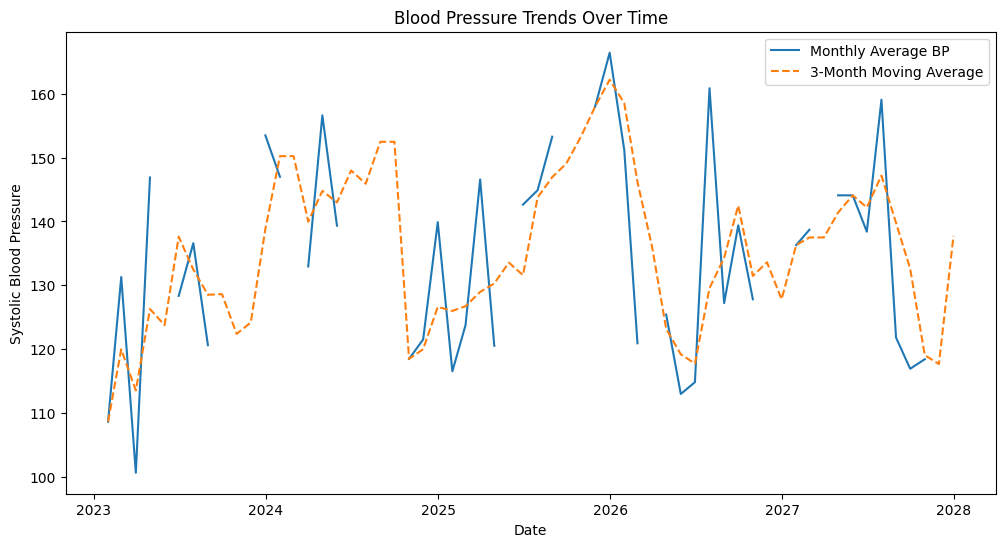

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Average BP')
plt.plot(monthly_bp_smooth, label='3-Month Moving Average', linestyle='--')
plt.title('Blood Pressure Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.legend()
plt.show()

## Statistical Modeling Tasks

### Analyze factors affecting baseline blood pressure

Prepare the feature matrix X and response variable y

In [56]:
X_baseline = baseline_df[['age', 'bmi', 'smoking', 'diabetes']]
y_bp_systolic = baseline_df['bp_systolic']

Add a constant term for the intercept

In [57]:
X_baseline = sm.add_constant(X_baseline)

Fit the OLS model

In [58]:
ols_model = sm.OLS(y_bp_systolic, X_baseline).fit()

Output summary to examine p-values and coefficients

In [59]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Wed, 06 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        05:33:48   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

Residuals vs Fitted Values

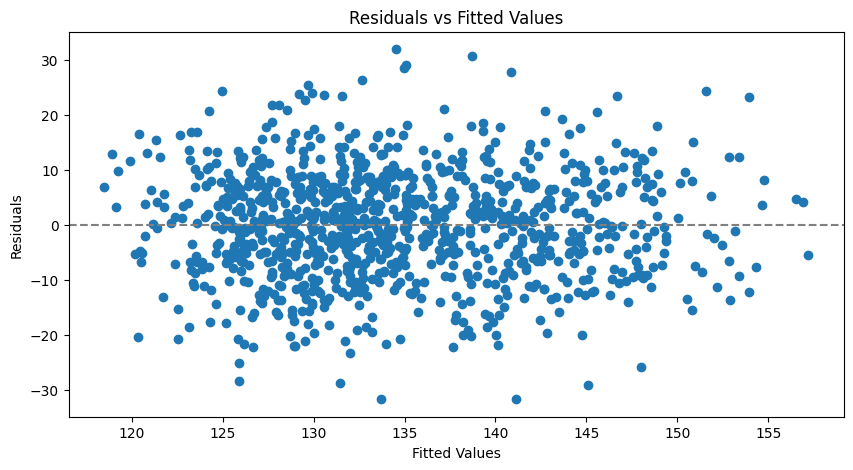

In [60]:
plt.figure(figsize=(10, 5))
plt.scatter(ols_model.fittedvalues, ols_model.resid)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Q-Q Plot

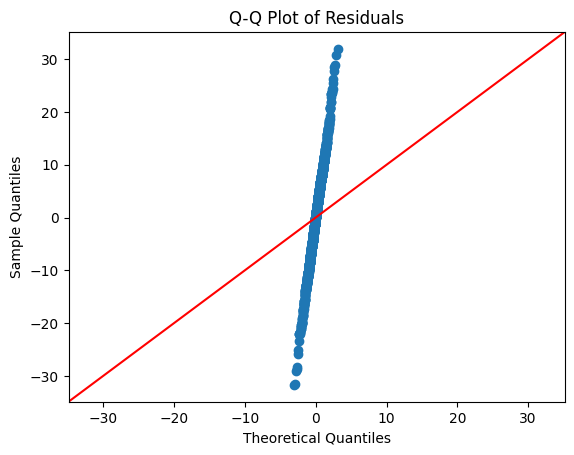

In [61]:
sm.qqplot(ols_model.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

### Model treatment effectiveness

Prepare feature matrix and outcome for GLM

In [62]:
X_treatment = treatment_df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y_treatment = treatment_df['outcome']

Add constant for intercept

In [63]:
X_treatment = sm.add_constant(X_treatment)

Fit GLM model

In [64]:
glm_model = sm.GLM(y_treatment, X_treatment, family=sm.families.Binomial()).fit()

Report odds ratios and confidence intervals

In [65]:
odds_ratios = np.exp(glm_model.params)
confidence_intervals = np.exp(glm_model.conf_int())
print("Odds Ratios:")
print(odds_ratios)
print("Confidence Intervals:")
print(confidence_intervals)

Odds Ratios:
const        0.281360
age          1.002744
bmi          1.030101
smoking      0.677929
diabetes     0.613448
adherence    1.129833
dtype: float64
Confidence Intervals:
                  0         1
const      0.072687  1.089105
age        0.993428  1.012147
bmi        1.001936  1.059058
smoking    0.456134  1.007574
diabetes   0.438726  0.857752
adherence  0.305350  4.180529


Model fit diagnostics

In [66]:
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Wed, 06 Nov 2024   Deviance:                       1312.8
Time:                        05:33:49   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

## Machine Learning Tasks (stretch goal)

### Build a prediction pipeline

Prepare features and target for prediction

In [67]:
X_ml = treatment_df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y_ml = treatment_df['outcome']

Create a pipeline with StandardScaler and Logistic Regression

In [68]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced')
)

### Validate model performance

Split data into training and testing sets

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, stratify=y_ml, random_state=42)

5-fold cross-validation setup

In [70]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

Evaluate the model using cross-validation

In [71]:
scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring_metrics)

Print cross-validation results

In [72]:
for metric in scoring_metrics:
    print(f"{metric.capitalize()}: {np.mean(scores['test_' + metric]):.4f}")

Accuracy: 0.5414
Precision: 0.4299
Recall: 0.5874
Roc_auc: 0.5473


Train final model and generate performance reports

In [73]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.54      0.58       185
           1       0.41      0.52      0.46       115

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.55      0.53      0.54       300



Confusion Matrix

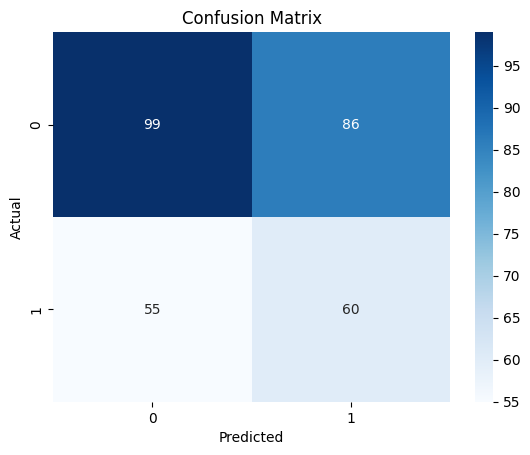

In [74]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC Curve

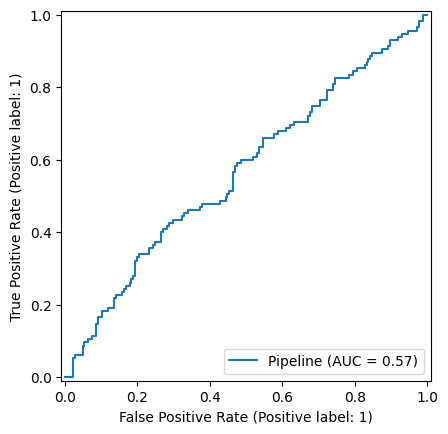

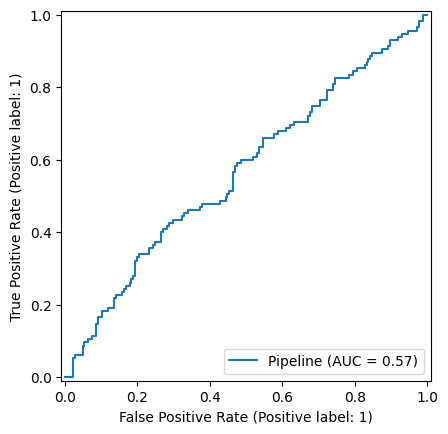

In [75]:
roc_display = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
roc_display.plot()
plt.show()